In [6]:
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np


In [7]:
def two_proportions_z_test(x1, n1, x2, n2):
    """
    Returns the z-statistic and two-sided p-value for a two-proportion z-test.
    """
    # Sample proportions
    p1 = x1 / n1
    p2 = x2 / n2
    
    # Pooled proportion
    p_pool = (x1 + x2) / (n1 + n2)
    
    # Difference in proportions
    diff = p2 - p1
    
    # Standard error under H0 (p1 = p2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    
    # z-statistic
    z_stat = diff / se
    
    # two-sided p-value
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    
    return z_stat, p_value



In [8]:
# Example usage:
if __name__ == "__main__":
    x1, n1 = 184, 2774
    x2, n2 = 138, 1609
    
    z, p = two_proportions_z_test(x1, n1, x2, n2)
    print(f"Z-statistic: {z:.4f}")
    print(f"P-value: {p:.6f}")

Z-statistic: 2.3774
P-value: 0.017433


In [10]:

def required_n_for_proportions(p0, p1, alpha=0.05, power=0.8):
    """
    Returns the approximate *per-group* sample size needed to detect
    a difference (p1 - p0) with significance alpha (two-sided) and
    power=power, based on a standard formula.
    """
    z_alpha = norm.ppf(1 - alpha/2)  # e.g. ~1.96 if alpha=0.05
    z_beta  = norm.ppf(power)       # e.g. ~0.84  if power=0.80

    p_avg = (p0 + p1) / 2.0  # average proportion (common choice)
    diff = p1 - p0
    if diff <= 0:
        return np.nan  # no positive effect => doesn't make sense

    numerator = (z_alpha * np.sqrt(2 * p_avg * (1 - p_avg))
                 + z_beta * np.sqrt(p0 * (1 - p0) + p1 * (1 - p1)))
    n = 2.0 * (numerator / diff)**2
    return n


def mde_for_n(n, p0, alpha=0.05, power=0.8, tol=1e-6):
    """
    For a given per-group sample size n and baseline p0,
    find the minimum detectable effect (delta), i.e., the smallest
    p1 - p0 that yields the desired power at significance alpha.
    
    We'll do a simple binary search for delta in [0, 0.5 - p0].
    (Because p1 cannot exceed 1, so max delta = 1 - p0,
    but we'll be conservative and go up to 0.5 if p0 is small.)
    """
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta  = norm.ppf(power)
    
    # We'll search for delta
    low, high = 0.0, 1.0 - p0
    for _ in range(100):  # 100 iterations is plenty for binary search
        mid = (low + high) / 2
        p1 = p0 + mid
        
        # Compute the "required n" if the effect is mid
        # If required_n <= n, it means we can detect mid with sample n
        req_n = required_n_for_proportions(p0, p1, alpha, power)
        
        if np.isnan(req_n):
            # can't detect negative or zero difference
            low = mid
            continue
        
        if req_n > n:
            # we don't have enough sample, need bigger effect
            low = mid
        else:
            # we can detect this effect, try smaller effect
            high = mid

    return (low + high) / 2


def plot_mde_vs_n(p0=0.05, alpha=0.05, power=0.8, n_min=100, n_max=5000, step=100):
    """
    Plots the MDE (minimum detectable effect) vs. sample size n.
    """
    ns = np.arange(n_min, n_max+1, step)
    deltas = []
    for n in ns:
        delta_n = mde_for_n(n, p0, alpha, power)
        deltas.append(delta_n)
    
    plt.figure(figsize=(8, 5))
    plt.plot(ns, deltas, marker='o')
    plt.title(f"MDE vs. sample size (p0={p0}, alpha={alpha}, power={power})")
    plt.xlabel("Sample size per group (n)")
    plt.ylabel("Minimum Detectable Effect (delta)")
    plt.grid(True)
    plt.show()





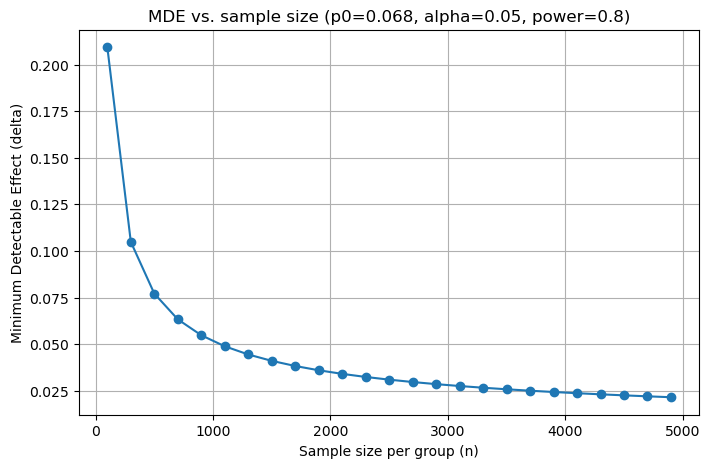

In [13]:
if __name__ == "__main__":
    # Example usage
    plot_mde_vs_n(
        p0= 0.068,     # baseline proportion
        alpha=0.05,  # two-sided significance
        power=0.80,  # desired power
        n_min=100,
        n_max=5000,
        step=200
    )